Starting from [02:14:55](https://www.youtube.com/watch?v=l8pRSuU81PU&t=8095s)

In [2]:
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
import time
import math

# Code from the previous notebook

In [3]:
@dataclass
class GPTConfig:
    block_size: int = 1024  # maximum sequence length
    vocab_size: int = (
        50257  # number of tokens (50k BPE merges + 256 byte tokens + 1 <|endoftext|> token)
    )
    n_layer: int = 12  # number of layers
    n_head: int = 12  # number of heads
    n_embd: int = 768  # embedding size


# Multi-Head Attention (in a single class)
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Bias (or mask)
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )

    def forward(self, x):
        # batch size, sequence length, embedding size (n_embd)
        B, T, C = x.size()
        # Query, Key, Value (extract them from c_attn)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        # n_head is treated as a batch dimension
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        # # Attention (Comment this since we will use flash attention)
        # att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
        # # apply the mask
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        # # apply the softmax
        # att = F.softmax(att, dim=-1)
        # apply the attention
        # y = att @ v

        # Flash attention (torch.compile will compile this into flash attention)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # transpose and reshape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(
            {
                # token embedding
                "wte": nn.Embedding(config.vocab_size, config.n_embd),
                # positional embedding
                "wpe": nn.Embedding(config.block_size, config.n_embd),
                # transformer layers
                "h": nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                # final layer norm (Before the Linear layer)
                "ln_f": nn.LayerNorm(config.n_embd),
            }
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # Initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if hasattr(module, "NANOGPT_SCALE_INIT"):
            # 1 / sqrt(2 * number of residual layers) note that each layer has two residual connections
            std *= (2 * self.config.n_layer) ** -0.5
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx, targets=None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert (
            T <= self.config.block_size
        ), f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)  # Shape is (T)
        pos_emb = self.transformer.wpe(pos)  # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx)  # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb  # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x)  # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1)
            )  # (B * T, vocab_size)
        return logits, loss

In [4]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        with open("input.txt", "r") as f:
            text = f.read()
        enc = tiktoken.get_encoding("gpt2")
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + (B * T) + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)
        self.current_position += B * T
        # reset if we reach the end
        if self.current_position + (B * T) + 1 > len(self.tokens):
            self.current_position = 0
        return x, y

In [5]:
# Set matmul to TF32 (it will work for Ampere GPUs)
# The improvment will not improve by the expected 8x due to memory bandwidth
torch.set_float32_matmul_precision("high")

model = GPT(GPTConfig(vocab_size=50304))
model.to("cuda")
model = torch.compile(model)

# AdamW betas & gradient norm clipping

In [6]:
times = []
train_loader = DataLoaderLite(8, 1024)
# set betas to (0.9, 0.95) and eps to 1e-8
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
losses = []
for i in range(10):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    # clip gradients norm (to avoid very large gradients)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(
        f"Step {i}, Loss: {loss.item()}, norm: {norm:.4f}, Time: {(t1 - t0 )* 1000:.3f}ms"
    )
    times.append(t1 - t0)

Step 0, Loss: 10.961965560913086, norm: 26.8432, Time: 21818.676ms
Step 1, Loss: 9.588728904724121, norm: 5.6657, Time: 223.082ms
Step 2, Loss: 9.100929260253906, norm: 5.0262, Time: 225.568ms
Step 3, Loss: 8.699085235595703, norm: 3.5660, Time: 222.778ms
Step 4, Loss: 8.48172664642334, norm: 2.7194, Time: 227.257ms
Step 5, Loss: 8.413750648498535, norm: 2.6810, Time: 235.440ms
Step 6, Loss: 8.324607849121094, norm: 2.3129, Time: 225.651ms
Step 7, Loss: 7.969107627868652, norm: 1.7272, Time: 225.883ms
Step 8, Loss: 7.668796539306641, norm: 1.6388, Time: 227.598ms
Step 9, Loss: 7.602723121643066, norm: 1.4358, Time: 231.248ms


# Learning rate scheduler

![Cosine with warmup](https://miro.medium.com/v2/resize:fit:1400/1*BJCssPOCn4u__NoAZs392w.png)

In [7]:
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50

In [8]:
# Andrej's implementation
def get_lr(it):
    # 1) Linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

In [9]:
# pytorch implementation (combines linear scheduling and cosine annealing)
optimizer = torch.optim.SGD(model.parameters(), lr=6e-4)


def get_lr_pytorch():
    # 1) Warmup Scheduler (Linear)
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer=optimizer,
        start_factor=1 / warmup_steps,
        end_factor=1,
        total_iters=warmup_steps,
    )

    # 2) Cosine Scheduler
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=(max_steps - warmup_steps), eta_min=min_lr
    )

    # 3) Combine Both Schedulers
    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer=optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[warmup_steps],
    )
    return scheduler

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/

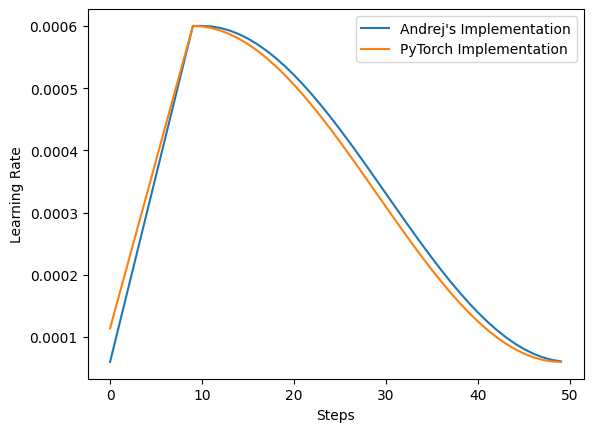

In [10]:
# Both graphs should be identical
lrs = []
lrs_pytorch = []
scheduler = get_lr_pytorch()

for i in range(max_steps):
    lrs.append(get_lr(i))
    scheduler.step()
    lrs_pytorch.append(scheduler.get_last_lr()[0])

# Plot the graphs
plt.plot(lrs, label="Andrej's Implementation")
plt.plot(lrs_pytorch, label="PyTorch Implementation")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.legend()

In [11]:
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
losses = []
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set lr for the current iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(
        f"Step {step}, Loss: {loss.item()}, lr: {lr:.4e}, norm: {norm:.4f}, Time: {(t1 - t0 )* 1000:.3f}ms"
    )
    times.append(t1 - t0)

Step 0, Loss: 7.1741414070129395, lr: 6.0000e-05, norm: 1.7669, Time: 227.182ms


Step 1, Loss: 7.085329532623291, lr: 1.2000e-04, norm: 1.7881, Time: 223.317ms
Step 2, Loss: 6.739221572875977, lr: 1.8000e-04, norm: 1.5870, Time: 224.496ms
Step 3, Loss: 6.669004440307617, lr: 2.4000e-04, norm: 1.4240, Time: 230.019ms
Step 4, Loss: 6.613946914672852, lr: 3.0000e-04, norm: 1.5314, Time: 236.721ms
Step 5, Loss: 6.7087883949279785, lr: 3.6000e-04, norm: 1.5298, Time: 230.985ms
Step 6, Loss: 6.906996726989746, lr: 4.2000e-04, norm: 2.5751, Time: 226.552ms
Step 7, Loss: 6.570232391357422, lr: 4.8000e-04, norm: 1.3464, Time: 224.849ms
Step 8, Loss: 6.639470100402832, lr: 5.4000e-04, norm: 5.3371, Time: 235.049ms
Step 9, Loss: 6.580402374267578, lr: 6.0000e-04, norm: 2.9929, Time: 235.152ms
Step 10, Loss: 6.719510555267334, lr: 6.0000e-04, norm: 2.4282, Time: 234.439ms
Step 11, Loss: 6.715445518493652, lr: 5.9917e-04, norm: 2.6444, Time: 228.423ms
Step 12, Loss: 6.710544586181641, lr: 5.9668e-04, norm: 1.5415, Time: 233.490ms
Step 13, Loss: 6.55912971496582, lr: 5.9254e-04,

# Weight Decay

In [12]:
@dataclass
class GPTConfig:
    block_size: int = 1024  # maximum sequence length
    vocab_size: int = (
        50257  # number of tokens (50k BPE merges + 256 byte tokens + 1 <|endoftext|> token)
    )
    n_layer: int = 12  # number of layers
    n_head: int = 12  # number of heads
    n_embd: int = 768  # embedding size


# Multi-Head Attention (in a single class)
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Bias (or mask)
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )

    def forward(self, x):
        # batch size, sequence length, embedding size (n_embd)
        B, T, C = x.size()
        # Query, Key, Value (extract them from c_attn)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        # n_head is treated as a batch dimension
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        # # Attention (Comment this since we will use flash attention)
        # att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
        # # apply the mask
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        # # apply the softmax
        # att = F.softmax(att, dim=-1)
        # apply the attention
        # y = att @ v

        # Flash attention (torch.compile will compile this into flash attention)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # transpose and reshape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(
            {
                # token embedding
                "wte": nn.Embedding(config.vocab_size, config.n_embd),
                # positional embedding
                "wpe": nn.Embedding(config.block_size, config.n_embd),
                # transformer layers
                "h": nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                # final layer norm (Before the Linear layer)
                "ln_f": nn.LayerNorm(config.n_embd),
            }
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # Initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if hasattr(module, "NANOGPT_SCALE_INIT"):
            # 1 / sqrt(2 * number of residual layers) note that each layer has two residual connections
            std *= (2 * self.config.n_layer) ** -0.5
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx, targets=None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert (
            T <= self.config.block_size
        ), f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)  # Shape is (T)
        pos_emb = self.transformer.wpe(pos)  # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx)  # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb  # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x)  # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1)
            )  # (B * T, vocab_size)
        return logits, loss

    # The goal of the function to separate the parameters (should be weight decayed and not weight decayed)
    def configure_optimizers(self, weight_decay, learning_rate, device):
        # start with all params requiring grad
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, others won't
        # all weights in matmuls and embeddings will be weight decayed
        # biases and layernorms won't be weight decayed
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": 0.1},
            {"params": nodecay_params, "weight_decay": 0.0},
        ]
        num_dcay_params = sum(p.numel() for p in decay_params)
        num_ndcay_params = sum(p.numel() for p in nodecay_params)
        print(
            f"num ecayed parameter tensors: {len(decay_params)} with {num_dcay_params:,} params"
        )
        print(
            f"num non-decayed parameter tensors: {len(nodecay_params)} with {num_ndcay_params:,} params"
        )
        fused = "cuda" in device
        # fused make it faster
        optimizer = torch.optim.AdamW(
            optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=fused
        )
        return optimizer

In [13]:
# Set matmul to TF32 (it will work for Ampere GPUs)
# The improvment will not improve by the expected 8x due to memory bandwidth
torch.set_float32_matmul_precision("high")

model = GPT(GPTConfig(vocab_size=50304))
model.to("cuda")
model = torch.compile(model)

In [15]:
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = model.configure_optimizers(0.1, 6e-4, "cuda")
losses = []
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set lr for the current iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(
        f"Step {step}, Loss: {loss.item()}, lr: {lr:.4e}, norm: {norm:.4f}, Time: {(t1 - t0 )* 1000:.3f}ms"
    )
    times.append(t1 - t0)

num ecayed parameter tensors: 50 with 124,354,560 params
num non-decayed parameter tensors: 98 with 121,344 params
Step 0, Loss: 10.815095901489258, lr: 6.0000e-05, norm: 29.5874, Time: 5957.323ms
Step 1, Loss: 9.53116226196289, lr: 1.2000e-04, norm: 7.9393, Time: 208.087ms
Step 2, Loss: 8.886503219604492, lr: 1.8000e-04, norm: 3.8841, Time: 204.878ms
Step 3, Loss: 8.761748313903809, lr: 2.4000e-04, norm: 4.9515, Time: 207.295ms
Step 4, Loss: 9.525464057922363, lr: 3.0000e-04, norm: 8.3081, Time: 219.947ms
Step 5, Loss: 8.886791229248047, lr: 3.6000e-04, norm: 3.7999, Time: 216.155ms
Step 6, Loss: 8.566642761230469, lr: 4.2000e-04, norm: 2.9776, Time: 206.392ms
Step 7, Loss: 8.15962028503418, lr: 4.8000e-04, norm: 3.0515, Time: 206.382ms
Step 8, Loss: 7.773521423339844, lr: 5.4000e-04, norm: 4.1853, Time: 205.144ms
Step 9, Loss: 7.561093330383301, lr: 6.0000e-04, norm: 1.7883, Time: 217.233ms
Step 10, Loss: 7.4016032218933105, lr: 6.0000e-04, norm: 2.6062, Time: 213.023ms
Step 11, Loss

# Gradient Accumulation

In [16]:
total_batch_size = 2**19
B = 16  # micro batch size
T = 1024  # sequence length
assert total_batch_size % (B * T) == 0  # total batch size must be divisible by B * T
grad_accum_steps = total_batch_size // (B * T)
print(
    f"total desired batch size: {total_batch_size:,}, grad_accum_steps: {grad_accum_steps:,}"
)

total desired batch size: 524,288, grad_accum_steps: 32


In [17]:
times = []
train_loader = DataLoaderLite(B, T)
optimizer = model.configure_optimizers(0.1, 6e-4, "cuda")
losses = []
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad()
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to("cuda"), y.to("cuda")
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set lr for the current iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(
        f"Step {step}, Loss: {loss.item()}, lr: {lr:.4e}, norm: {norm:.4f}, Time: {(t1 - t0 )* 1000:.3f}ms"
    )
    times.append(t1 - t0)
    if step == 5:
        break

num ecayed parameter tensors: 50 with 124,354,560 params
num non-decayed parameter tensors: 98 with 121,344 params
Step 0, Loss: 6.038639068603516, lr: 6.0000e-05, norm: 19.2737, Time: 37629.677ms
Step 1, Loss: 5.928457260131836, lr: 1.2000e-04, norm: 15.8229, Time: 12712.087ms
Step 2, Loss: 6.07780122756958, lr: 1.8000e-04, norm: 13.3442, Time: 12849.101ms
Step 3, Loss: 6.032467842102051, lr: 2.4000e-04, norm: 16.1737, Time: 13016.075ms
Step 4, Loss: 5.970197677612305, lr: 3.0000e-04, norm: 14.1002, Time: 13197.363ms
Step 5, Loss: 5.917179107666016, lr: 3.6000e-04, norm: 18.4995, Time: 13371.280ms
Step 6, Loss: 5.781548023223877, lr: 4.2000e-04, norm: 21.6698, Time: 13468.771ms
Step 7, Loss: 6.006679058074951, lr: 4.8000e-04, norm: 18.5777, Time: 13610.349ms


KeyboardInterrupt: 

## Fixing an issue

In [8]:
# simple mlp
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1),
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
# reduction = `mean` (default) i.e., loss = 1/4 * [(y[0] - yhat[0])**2 + ... + (y[3] - yhat[3])**2]
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])


In [15]:
# same network with gradient accumulation (batch_size = 4, 1 micro step)
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])
# Loss is not the same (no division by 4)
print(f"Dividing by 4: {net[0].weight.grad.view(-1)[:10] / 4}")

tensor([-0.0598,  0.0042,  0.0167, -0.0161,  0.0235, -0.0320, -0.0311, -0.0550,
        -0.0410, -0.0536])
Loss is not the same (no division by 4)
Dividing by 4: tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])


In [18]:
times = []
train_loader = DataLoaderLite(B, T)
optimizer = model.configure_optimizers(0.1, 6e-4, "cuda")
losses = []
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to("cuda"), y.to("cuda")
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss /= (
            grad_accum_steps  # divide by grad_accum_steps since the reduction is mean
        )
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set lr for the current iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss_accum)
    print(
        f"Step {step}, Loss: {loss_accum}, lr: {lr:.4e}, norm: {norm:.4f}, Time: {(t1 - t0 )* 1000:.3f}ms"
    )
    times.append(t1 - t0)
    if step == 5:
        break

num ecayed parameter tensors: 50 with 124,354,560 params
num non-decayed parameter tensors: 98 with 121,344 params
Step 0, Loss: 5.883791923522949, lr: 6.0000e-05, norm: 0.7356, Time: 13598.408ms
Step 1, Loss: 5.885821342468262, lr: 1.2000e-04, norm: 0.5531, Time: 13777.442ms
Step 2, Loss: 5.879245758056641, lr: 1.8000e-04, norm: 0.6695, Time: 13902.858ms
Step 3, Loss: 5.846792221069336, lr: 2.4000e-04, norm: 0.4080, Time: 14040.436ms
Step 4, Loss: 5.838709354400635, lr: 3.0000e-04, norm: 0.5806, Time: 14143.143ms
Step 5, Loss: 5.813776016235352, lr: 3.6000e-04, norm: 0.6831, Time: 14265.640ms
